# Real or Not? NLP with Disaster Tweets
## Daniel Díez Mallo
### https://www.linkedin.com/in/danieldiezmallo/

This notebook contains the code used to solve the Kaggle challenge "Real or Not? NLP with Disaster Tweets", avialable in https://www.kaggle.com/c/nlp-getting-started. In it, a set of tweets that refer to different disasters is provided, being some of them real and some fake. The objectives is, using supervised learning and NLP, to correctly classify new tweets in real or fake, based on the text of the tweet, location or keywords.

## 1. Import and observe dataset

In [1]:
# Load libraires for data wrangling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 


# Set seed for reproducibility
np.random.seed(5)

train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

print("Number of tweets in train %s " % (len(train)))
print("Number of tweets in test %s " % (len(test)))

# Visualize head and a summary of numerical values of train data
print("------------train data head------------")
print(train.head(5))
print("------------train data summary------------")
print(train.describe())
print("------------train data missing counts------------")
print("Tweets missing location:", np.sum(train['location'].isna()))
print("Tweets missing keywords:", np.sum(train['keyword'].isna()))
print("Tweets missing text:", np.sum(train['text'].isna()))

Number of tweets in train 7613 
Number of tweets in test 3263 
------------train data head------------
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
------------train data summary------------
                 id      target
count   7613.000000  7613.00000
mean    5441.934848     0.42966
std     3137.116090     0.49506
min        1.000000     0.00000
25%     2734.000000     0.00000
50%     5408.000000     0.00000
75%     8146.000000     1.00000
max    10873.000000     1.00000
------------train data missing 

The data consists of a text, that corresponds to the tweet, and a label that indicates whether the tweet is referring to a real disaster or not. It also contains the location of the tweet if it is available, and the keyword that the tweet may have if available too.

It is possible to see as well that, out 7613 tweets in the training, 61 of them are missing the keyword, and 2533 are missing the location, and none of them are missing the text. This is the reason why the main source where features for model training will be extracted is the text of the tweet.

It is also interesting to see that in the training data there are more observation of tweets about fake disasters than real disasters, as it can be seen in the countplot bellow, so the modeling might have to take this into account to avoid skeweness.

Text(0.5, 1.0, 'Count of labels in train data')

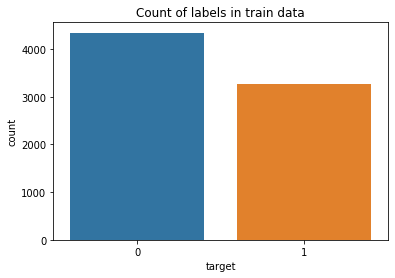

In [2]:
ax = sns.countplot(
                    x='target', 
                    data=train)
ax.set_title('Count of labels in train data')

Then, text duplicates are found in the text. Having duplicated and/or misslabelled data my cause an undesired bias on the data, and sometimes, the same tweet may have different labelling, which adds unnecessary variance to the dataset.

There are, for example, very simillar tweets, probably generated by the same bot, that only differ in maybe a link, and are often labelled differently. It is the case, for instance, of the tweets that appear bellow concerning a market crash in China, where the only thing that changes is the link, the tweet is labelled as fake some times and others as real. 

In order to solve this, the text needs to be cleaned first, removing the links and parts that can be premade by a bot in order to find the structure that the tweet really follows. This will be performed in a further section of this notebook.

In [3]:
table = train.groupby('text')['target'].value_counts()
print("There are {} duplicated tweets in the data".format(len(train)-len(table)))
print("\n-------------------------------\n")

print("Very simillar tweets (only change is the link):")
print(table[[2]])
print(table[[3]])
print("\n-------------------------------\n")

print("Most duplicated tweets:")
print(table.sort_values(ascending=False))
print("\n-------------------------------\n")

There are 92 duplicated tweets in the data

-------------------------------

Very simillar tweets (only change is the link):
text                                                                                             target
#360WiseNews : China's Stock Market Crash: Are There Gems In The Rubble? http://t.co/9Naw3QOQOL  1         1
Name: target, dtype: int64
text                                                                                             target
#360WiseNews : China's Stock Market Crash: Are There Gems In The Rubble? http://t.co/aOd2ftBMGU  1         1
Name: target, dtype: int64

-------------------------------

Most duplicated tweets:
text                                                                                                                                          target
11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charged with manslaughter over the fatal sh...      1         10
#Bestnaijamade: 16yr old PKK suic

Now, a statistical analysis of other possible variables is performed. For this, an odds ratio is calculated, from the target and the prportion of tweets for which the location is missing. The objective is to determine if fake disaster tweets have a higher probability to not have a location than real disaster ones.

The results show that the odds ratio for this is not in favor of any of the cases, i.e., there is not a significant higher or lower probability of the tweet being real if the location is missing than if it is not.

In [4]:
import scipy.stats as stats

# Calculate a crosstable with the groups by target and missing location flag
table = pd.crosstab(train['target'], 
                            train['location'].isna(),  
                            margins = False
)
print(table)

# Calculate and print oddstario for this table
oddsratio, pvalue = stats.fisher_exact(table)
print("OddsR: ", oddsratio, "p-Value:", pvalue)

location  False  True 
target                
0          2884   1458
1          2196   1075
OddsR:  0.9683087594104257 p-Value: 0.52299711249183


The same approach is used with the missing keywords. The result here is much more interesting, showing that a tweet that is missing it's keyword is 2.95 time more likely to be a real disaster tweet. However, as the  number of tweets that are missing the keyword is very low in both cases, no conclussions can be inferred from this.

In [5]:
table = pd.crosstab(train['target'], 
                    train['keyword'].isna(),  
                    margins = False
)
print(table)
oddsratio, pvalue = stats.fisher_exact(table)
print("OddsR: ", oddsratio, "p-Value:", pvalue)

keyword  False  True 
target               
0         4323     19
1         3229     42
OddsR:  2.9594627634431387 p-Value: 6.917009114930886e-05


## 2.Text cleaning, tokenization and lemmatization

It is necesary, in order to be able to statisticly model the text of the tweets, to tokenize the words contained in the text, and convert them into numerical features that can be understood by a computer. For this, a tfidf vector will be created in a further section of this notebook

In order to do so, a function that cleans the text and another one that tokenizes and lemmatizes it will be defined. The cleaning one is the one that is declared in this section of the notebook. It removes noise, puntuation signs, special characters, digits, mentions, hashtags and links, incluiding this as part of the text and also as external variables that are not included in the vector.

The tokenizing function will be decladed in the next section of the document.

In [6]:
import re # import the regex module
def clean_text(text):
    """
    Function that performs text cleanse
    
    Arguments:
    ----------
    text: a piece of text
    
    Returns: 
    ----------
    text: cleaned text
    """
    # Lowercase all data
    text = text.lower()
    # Unwanted characters are removed
    text = re.sub(r'http[s]{0,1}?://\S+', 'http', text) # Remove links but leave the http identifier and the domains
    text = re.sub(r'www\.\S+', 'http', text) # Remove links but leave the http identifier and the domains
    text = re.sub(r'([@#])\S+', r'\1', text) # get mentions and hashtags names and their identifier
    text = re.sub(r'\[.*?\]', '', text) # remove text in square brackets
    text = re.sub(r'<.*?>+', '', text) # remove everything between <>>>
    text = re.sub(r'\n', '', text) # remove line breaks
    text = re.sub(r'(\w*)\d(\w*)', r'', text) # remove digits
    text = re.sub(r'[^@#a-z\s]', '', text) # remove anything that is not a letter or a space
    text = re.sub(' +', ' ', text) # Remove multiple spaces

    return text

The text is then fully clean, using the same rules for both train and test data, and cleaning the keywords and locations as well, with the function that is declared above. Then the missing locations and keywords are indivdually declared, so they do not share the same identifier.

In [7]:
# Clean train data
train['text'] = train['text'].apply(clean_text)
train['keyword'] = train['keyword'].astype(str).apply(clean_text)
train['location'] = train['location'].astype(str).apply(clean_text)

# Clean test data
test['text'] = test['text'].apply(clean_text)
test['keyword'] = test['keyword'].astype(str).apply(clean_text)
test['location'] = test['location'].astype(str).apply(clean_text)

# Identify missing locations and keywords properly
train['keyword'] = train['keyword'].replace('nan', 'MissingKeyword')
train['location'] = train['location'].replace('nan', 'MissingLocation')
test['keyword'] = test['keyword'].replace('nan', 'MissingKeyword')
test['location'] = test['location'].replace('nan', 'MissingLocation')

print(train.head(5))

id         keyword         location  \
0   1  MissingKeyword  MissingLocation   
1   4  MissingKeyword  MissingLocation   
2   5  MissingKeyword  MissingLocation   
3   6  MissingKeyword  MissingLocation   
4   7  MissingKeyword  MissingLocation   

                                                text  target  
0  our deeds are the reason of this # may allah f...       1  
1              forest fire near la ronge sask canada       1  
2  all residents asked to shelter in place are be...       1  
3   people receive # evacuation orders in califor...       1  
4  just got sent this photo from ruby # as smoke ...       1  


As it has been mentioned before, there are several tweets that are duplicated or that are very simillar, which look like they have been generated by a bot. In order to avoid bias in the training set, these tweets that have already been cleaned (so simillar tweets are now identical tweets), will be groupped again. It is possible to see bellow how some tweets can be found up to 24 times within the data.

For this reason, the tweets will be grouped by their text, and for all of the repeated ones, the keywords, location and label will imputted as the mode of all the respective repeated tweets. This will preven overfitting to a particular set of words, displayed many times within the training data.

In [8]:
table = train.groupby(['text']).size()
print("Most duplicated tweets:")
print(table.sort_values(ascending=False))
print("\n-------------------------------\n")


# Group train data by unique tweet text and select the mode among the keyword, location and target
train_group = train.groupby(['text'])['keyword', 'location', 'target'].agg(lambda x: x.value_counts().index[0])
train_group = train_group.reset_index()

# New train data is the grouped train data
train = train_group
print(train.head(5))

Most duplicated tweets:
text
watch this airport get swallowed up by a sandstorm in under a minute http                                                         24
wreckage conclusively confirmed as from malaysia pm investigators and the families of those who were http                         20
families to sue over legionnaires more than families affected by the fatal outbreak of legionnaires disea http                    19
# funtenna hijacking computers to send data as sound waves http # #                                                               17
christian attacked by muslims at the temple mount after waving israeli flag via pamela geller http                                15
                                                                                                                                  ..
maryland mansion fire that killed caused by damaged plug under christmas tree report says into the flames firefighters bravery     1
mass murderer che guevara greeting a wom

## 3. Create a TfidfVectorizer

In this section, both the training and test text datasets are going to be converted into a set of word vectors. The objective of this step is to create a statistical quantification of the meaning of the words contained in all of the tweets. This way, it is possible to create a set of features that can then be fed to a supervised learning algorithm to create a model.

One approach to this problem, is to simply count the number of words that appear, and use this count vectorizer as the imput. However, it was decided to use a "term frecuency inverse document frecuency" vector, of TFID vector. It gives each word a score based on how many times it appears in a document or tweet, but it also pensalizes the words that appear in a lot of documents. This way, the most relevant words would be those that appear a lot in a tweet, but do not appear in many of them.

Bellow, a function that tokenizes the text into individual entities and lemmatizes it (finds the root of every word) is defined. This function will be the tokenize function that the vectorizer will use.

In [9]:

from nltk import sent_tokenize, word_tokenize
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english") # Stemmer that will be used by the lemmatizing function
def tokenize_and_stem_text(text):
    """
    Function that performs tokenization on an already cleaned piece of text. It requires a stemmer to have been creted globally.
    
    Arguments:
    ----------
    text: a piece of text. The text should already be cleaned
    
    Returns:
    ----------
    tokens: tokenized text
    """    
    # Tokenize by sentence, then by word
    tokens = [word for sentence in sent_tokenize(text) for word in word_tokenize(sentence)]

    # Stem the filtered_tokens
    tokens = [stemmer.stem(word) for word in tokens]
    # print(text)

    return tokens

This function will then be used to create a TFIDF vector that gives all of the identified tokens a score based on how many times they appear in the tweet they are in, and among the tweets, so very common words are not taken into account as much as words that are unique to some tweets or less uncommon than the rest.

In the next code sections, the vectorizer is called and the vector is created. It is fit with the text that is present in the train data, and, using this encoding, it turns both the training and test text into a TFIDF vector.

To use as much information as possible, the already cleaned location and keyword will be added to the tweet text.

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a vectorizer object
max_features = None
min_frequency = 2/len(train) # Minimum frequency of a word among texts
tfidf_vectorizer = TfidfVectorizer(
                                    max_features=max_features, # max features to evaluate
                                    max_df=0.8, # drops words that appear in this proportion of the documents (topic stopwprds)
                                    min_df=0, # drops terms that appear in only two or less tweets
                                    ngram_range=(1,1), # combinations of words of only one word or two words
                                    stop_words='english', # language of stopwords to be removed from the text
                                    # use_idf=True, # enable inverse frecuency to find frequency among documents
                                    tokenizer=tokenize_and_stem_text # function to tokenize the words in a document (previously defined)
)

# Before creating the vectorizer, the keywords are added to the text, at the beginning
train['text'] = train['keyword'] + ' ' + train['location'] + ' ' + train['text']
test['text'] = test['keyword'] + ' ' + test['location'] + ' ' + test['text']

# Fit the TFIDF vector with the text in the training data and transform it
x_train_tfidf = tfidf_vectorizer.fit_transform(train['text'])

# Transform the test data into another vecor for the predictions
x_test_tfidf = tfidf_vectorizer.transform(test['text'])

print(x_train_tfidf.shape)
print(x_test_tfidf.shape)

(6867, 10445)
(3263, 10445)


Now that the vectorizer has been created and a TFIDF score has been given to each word, it is possible to examine them, by creating a Pandas DataFrame. It is possible to see that the least scored tokens are the ones corresponding to links, mentions and hashtags, as these appear in many of the documents.

In [11]:
tfidf_features = tfidf_vectorizer.get_feature_names()
features = pd.DataFrame(
                        zip(tfidf_features, tfidf_vectorizer.idf_), 
                        columns=['word', 'tfidf']
                        )
features = features.sort_values(by=['tfidf'], ascending=False)
print(features)

word     tfidf
5222  leonardvill  9.141481
5935          moe  9.141481
5977    moonlight  9.141481
5976     moonbeam  9.141481
5973    monwabisi  9.141481
...           ...       ...
4882         just  4.120895
5282         like  3.905039
0               #  2.468183
1               @  2.257506
4316         http  1.739030

[10445 rows x 2 columns]


## 4. Create train and test data and labels

In this section, data is divided into target and labels. First the labels are extarcted and saved in a different array so they can be fed to the cross validation algorithms.

In [12]:
# Take labels on one side
y_train = train['target']
print(y_train.shape)

(6867,)


Then, a new dataframe of features extracted from the text is created, such as the ammount of mentions, hashtags and links in the text, and all the features that could not be extracted by the vectorizer. These features will then be fed to a different machine learning algorithm than the word vecotr, and their result will be combined by the use of a stacking algorithm.

These features are also normalized to avoid bias.

In [13]:
# Create a numpy array that counts number of mentions, hashtags and links in a tweet
dense_features = ['mentions', 'hashtags', 'links', 'n_words', 'avg_len_words']

# Train and test text is joined together so the normalization is consistent in both dataframes
all_text = train['text'].append(test['text'])

from statistics import mean
# Perform the counts
dense = np.transpose(np.array([
                all_text.str.count('@'),
                all_text.str.count('#'),
                all_text.str.count('http') + all_text.str.count('www.'),
                [len(tweet.split()) for tweet in all_text],
                # [mean([len(word) for word in tweet.split()]) for tweet in all_text]
]))

# This array is then normalized
from sklearn.preprocessing import Normalizer
dense = Normalizer().fit_transform(dense)

# Divide the counts into train and test
x_train_dense = dense[:train.shape[0],:]
x_test_dense = dense[-test.shape[0]:,:]
print(x_train_dense.shape)
print(x_test_dense.shape)

(6867, 4)
(3263, 4)


## 5. Model training and selection

In this section a supervised learning will be trained, using different parameter combinations. Its performance will then be evaluated by cross validation in 5 folds. As there are no target labels available for the test data, it is not possible to establish what the performance of the algorithm is when it is used with new test data. For each best model, the best average cross validation score will be printed. For this purpose, a grid search among serveral parameter combinations will be performed.

For this step two different dataframes have been created:

* A sparse matrix that contains the word features obtained by the cleanse, tokenization and stemming of the text applied into a TFID vectorizer. This data will be used to train a Naive Bayes model, as the ammount of features that need to be proccesed is very hihg, and this algorithm has a very good performance when high dimensionality is involved.
* A dense matrix that contains the counts and other features that were not proccessed by the vectorizer. This data will be used to train a gradient boosting algorithm.

Then, the results of the two previous steps will be combined into a gradient boosting algorithm to using a stacking method, trying to increase the performance of the two previous models.

In order to train and select the best algorithm for each step, a function that finds the best possible model for each algorithm by searching over different combinations of parameters is created.

In [14]:
from sklearn.model_selection import GridSearchCV

def fit_model_GridSearchCV(this_model, X_, y_, param_grid):    
      """Function to find best parameters for a model in a 2 parametere grid

      Parameters:
      ----------
      model: scikit-learn like model

      X: train data (np.array)
            
      y: train labels (np.array)

      param_grid: grid of parameters to try and iterate

      n_iter: number of parameter combinations to try

      Returns:
      ----------
      best_model: a dictionary that contains the best model and the obtained score by that model
      """

      # Fit to data and find the best parameters for this estimator
      grid_search = GridSearchCV(
                                    estimator=this_model, 
                                    param_grid=param_grid, 
                                    cv=4, n_jobs=-1, verbose=5)
      grid_search.fit(X_, y_)
      best_model = grid_search.best_estimator_

      print("Best model parameters: ", grid_search.best_params_)
      print("Best model train score on cross validation:", grid_search.best_score_)

      # Return best model for future use
      return best_model


### Naive Bayes and SVM model an with sparse data

The first approeach will be to train a Mulinomial Naive Bayes model that is very fast to train, to see how good the performance in cross validation is.

------------ MultinomialNB ------------
Fitting 4 folds for each of 7 candidates, totalling 28 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:    4.3s finished
Best model parameters:  {'alpha': 0.75}
Best model train score on cross validation: 0.777486006519204
MOST relevant features in model:
---------------------------------------


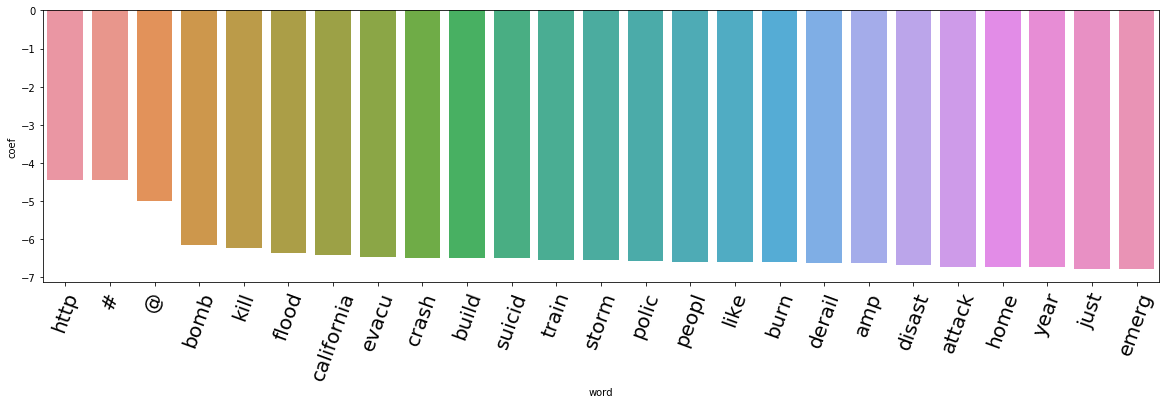

In [15]:
from sklearn.naive_bayes import MultinomialNB

print("------------ MultinomialNB ------------")

model_MultinomialNB = MultinomialNB()
param_grid = dict(
                alpha=[0.75, 1, 1.25, 1.5, 1.75, 2, 10]
)

model_MultinomialNB = fit_model_GridSearchCV(model_MultinomialNB, x_train_tfidf, y_train, param_grid)
# Print most important features
coefs = pd.DataFrame(
                zip(tfidf_features, model_MultinomialNB.coef_[0]), 
                columns=['word', 'coef']
                )
coefs = coefs.sort_values(by=['coef'], ascending=False)
print("MOST relevant features in model:")
fig, ax = plt.subplots(figsize=(20,5))
g = sns.barplot(x='word', y='coef', data=coefs.head(25), ax=ax)
g.set_xticklabels(g.get_xticklabels(), rotation=70, size=20)
print("---------------------------------------")

To see if there is an improvement, a support vector machine model is also trained on the TFIDF data. There is some improvement, so this model is taken for future use, instead of the Naive Bayes model.

In [16]:
from sklearn.svm import SVC

print("------------ SVC ------------")

model_SVC = SVC()
param_grid = dict(
                kernel=['linear', 'rbf'],
                C=[0.1, 0.5, 1, 2]
)

model_SVC = fit_model_GridSearchCV(model_SVC, x_train_tfidf, y_train, param_grid)
print("---------------------------------------")

------------ SVC ------------
Fitting 4 folds for each of 8 candidates, totalling 32 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:  1.2min finished
Best model parameters:  {'C': 0.5, 'kernel': 'linear'}
Best model train score on cross validation: 0.7731181772023356
---------------------------------------


### Logistic Regression with dense data

After this, a model that takes the dense features is created, to see if it performs well and can be used in stacking. The result is not satisfactory, as it cannont reach a 60% of cross validation accuracy.

In [17]:
from sklearn.linear_model import LogisticRegression

print("------------ LogisticRegression ------------")

model_LogisticRegression = LogisticRegression()
param_grid = dict(
                penalty=['l1', 'l2'],
                C=[0.01,0.1,0.5,1,5,10,25,50]
)

model_LogisticRegression = fit_model_GridSearchCV(model_LogisticRegression, x_train_dense, y_train, param_grid)

coefs = pd.DataFrame(
                zip(dense_features, model_LogisticRegression.coef_[0]), 
                columns=['word', 'coef']
                )
coefs = coefs.sort_values(by=['coef'], ascending=False)
print("MOST relevant features in model:")
print(coefs.head(15))
print("LEAST relevant features in model:")
print(coefs.tail(15))

print("---------------------------------------")

------------ LogisticRegression ------------
Fitting 4 folds for each of 16 candidates, totalling 64 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.1s
Best model parameters:  {'C': 50, 'penalty': 'l2'}
Best model train score on cross validation: 0.5907952220561423
MOST relevant features in model:
       word       coef
3   n_words  10.937339
2     links   5.509932
1  hashtags   3.001462
0  mentions  -1.510286
LEAST relevant features in model:
       word       coef
3   n_words  10.937339
2     links   5.509932
1  hashtags   3.001462
0  mentions  -1.510286
---------------------------------------
[Parallel(n_jobs=-1)]: Done  57 out of  64 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:    0.6s finished


### Gradient Boosting for stacking

With the two models that were trained before, a stacking gradient boosting model is trained. It uses the predictions made by both of the models before as training data, and creates a new prediction based on this data.

In [18]:
predictions_model_MultinomialNB = model_MultinomialNB.predict(x_train_tfidf)
predictions_model_LogisticRegression = model_LogisticRegression.predict(x_train_dense)

x_train_stack = np.column_stack((predictions_model_MultinomialNB, predictions_model_LogisticRegression))

from sklearn import ensemble

print("------------ Stacking: GradientBoostingClassifier ------------")
model_Stacking = ensemble.GradientBoostingClassifier()
param_grid = dict(
                n_estimators=[2,4,6,8,10,15,20], 
                max_depth=[1,2,3,5,10]
)

model_Stacking = fit_model_GridSearchCV(model_Stacking, x_train_stack, y_train, param_grid)

print("---------------------------------------")

------------ Stacking: GradientBoostingClassifier ------------
Fitting 4 folds for each of 35 candidates, totalling 140 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    2.3s
Best model parameters:  {'max_depth': 1, 'n_estimators': 2}
Best model train score on cross validation: 0.8840847320026121
---------------------------------------
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    3.5s finished


As seen in the simplicity of the obtained model, for which the most effective forest is the one with just 1 level of depth and 2 estimators, there is no need of using stacking to improve the performance in this problem. Therefore, no stacking will be used to generate the predictions on the test data. Therefore, the obtained improvement in accuracy can only be tracked back to overfitting of the model to the training data.

## 6. Create and save predictions for submission

In this section, the previously found best models are used to predict the target labels on the test data. As a recap, using stacking has not been found as an increase on real performance, leading to an overfit model. This is why, for the predicions, only the tfidf vector naive bayes model is taken into account.

The results will be saved in a csv file, that will be uploaded into the Kaggle competion for evaluation.

In [21]:
# Create a DataFrame for to store the submissions
submission = pd.DataFrame(test['id'])

# Add the predictions on test data to the submissions dataframe
predictions_model_MultinomialNB = model_MultinomialNB.predict(x_test_tfidf)
submission['target'] = predictions_model_MultinomialNB

# Add the predictions on test data to the submissions dataframe
# predictions_model_SVC = model_SVC.predict(x_test_tfidf)
# submission['target'] = predictions_model_SVC

# predictions_model_LogisticRegression = model_LogisticRegression.predict(x_test_dense)

# x_test_stack = np.column_stack((predictions_model_MultinomialNB, predictions_model_LogisticRegression))

# submission['target'] = model_Stacking.predict(x_test_stack)

# Save the submissions
submission.to_csv("submission.csv", index=False)
print(submission.shape)

(3263, 2)


Finally, a small summary of the generated predictions is plotted.

0    2190
1    1073
Name: target, dtype: int64


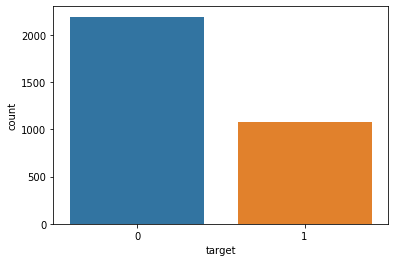

In [22]:
# Plot info on the submissions
print(submission['target'].value_counts())
ax = sns.countplot(x='target', data=submission)

## 7. Competition results

When submited to the Kaggle competion, the results obtained in this notebook scored a 0.80140, on top 38% percentile.